Training Data

In [45]:
# install packages
!pip install doubleml
!pip install econml

# load data
import doubleml as dml
from doubleml.datasets import fetch_bonus
# load data set on Pennsylvania reemployment bonus experiment
# treatment (tg) is bonus for jobseeker; outcome (inuidur1) is weeks in unemployment
df_bonus = fetch_bonus('DataFrame')
print(df_bonus.head(5))
dml_data_bonus = dml.DoubleMLData(df_bonus,
                                y_col='inuidur1',
                                d_cols='tg',
                                x_cols=['female', 'black', 'othrace', 'dep1', 'dep2',
                                        'q2', 'q3', 'q4', 'q5', 'q6', 'agelt35', 'agegt54',
                                        'durable', 'lusd', 'husd'])

   index   abdt  tg  inuidur1  inuidur2  female  black  hispanic  othrace  \
0      0  10824   0  2.890372        18       0      0         0        0   
1      3  10824   0  0.000000         1       0      0         0        0   
2      4  10747   0  3.295837        27       0      0         0        0   
3     11  10607   1  2.197225         9       0      0         0        0   
4     12  10831   0  3.295837        27       0      0         0        0   

   dep  ...  recall  agelt35  agegt54  durable  nondurable  lusd  husd  muld  \
0    2  ...       0        0        0        0           0     0     1     0   
1    0  ...       0        0        0        0           0     1     0     0   
2    0  ...       0        0        0        0           0     1     0     0   
3    0  ...       0        1        0        0           0     0     0     1   
4    1  ...       0        0        1        1           0     1     0     0   

   dep1  dep2  
0   0.0   1.0  
1   0.0   0.0  
2   0.0 

In [46]:
# partialling out based on lasso regression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegressionCV
ml_l = LassoCV()   # outcome model E(Y|X)
ml_m = LogisticRegressionCV(penalty="l1", solver="saga")
est= dml.DoubleMLPLR(dml_data_bonus, ml_l, ml_m) #partialling out
est.fit()   # fit the model
print(est)  # ATE estimate

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


================== DoubleMLPLR Object ==================

------------------ Data Summary      ------------------
Outcome variable: inuidur1
Treatment variable(s): ['tg']
Covariates: ['female', 'black', 'othrace', 'dep1', 'dep2', 'q2', 'q3', 'q4', 'q5', 'q6', 'agelt35', 'agegt54', 'durable', 'lusd', 'husd']
Instrument variable(s): None
No. Observations: 5099


------------------ Score & Algorithm ------------------
Score function: partialling out

------------------ Machine Learner   ------------------
Learner ml_l: LassoCV()
Learner ml_m: LogisticRegressionCV(penalty='l1', solver='saga')
Out-of-sample Performance:
Regression:
Learner ml_l RMSE: [[1.20322555]]
Classification:
Learner ml_m Log Loss: [[0.65005473]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit Summary       ------------------
        coef   std err         t     P>|t|     2.5 %    97.5 %
tg -0.077533  0.035299 -2.196478  0.028058 -0.146718 -0.0

In [47]:
# partialling out based on the random forest
from sklearn.ensemble import RandomForestRegressor
learner = RandomForestRegressor(max_features = 'sqrt')
ml_l = learner     # outcome model E(Y|X)
ml_m = learner     # treatment model E(D|X)
est=dml.DoubleMLPLR(dml_data_bonus, ml_l, ml_m) #partialling out
est.fit()   # fit the model
print(est)  # ATE estimate

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


================== DoubleMLPLR Object ==================

------------------ Data Summary      ------------------
Outcome variable: inuidur1
Treatment variable(s): ['tg']
Covariates: ['female', 'black', 'othrace', 'dep1', 'dep2', 'q2', 'q3', 'q4', 'q5', 'q6', 'agelt35', 'agegt54', 'durable', 'lusd', 'husd']
Instrument variable(s): None
No. Observations: 5099


------------------ Score & Algorithm ------------------
Score function: partialling out

------------------ Machine Learner   ------------------
Learner ml_l: RandomForestRegressor(max_features='sqrt')
Learner ml_m: RandomForestRegressor(max_features='sqrt')
Out-of-sample Performance:
Regression:
Learner ml_l RMSE: [[1.25510611]]
Learner ml_m RMSE: [[0.49544025]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit Summary       ------------------
       coef   std err         t     P>|t|     2.5 %    97.5 %
tg -0.07191  0.035466 -2.027542  0.042607 -0.141423 

In [48]:
# Causal Forest
from econml.dml import CausalForestDML
from pandas import concat
from sklearn.ensemble import RandomForestClassifier
from pandas import DataFrame
est = CausalForestDML(criterion='het', n_estimators=500,
                      min_samples_leaf=10,
                      max_depth=10, max_samples=0.5,
                      discrete_treatment=True,
                      model_y=RandomForestRegressor(max_features = 'sqrt'),
                      model_t=RandomForestClassifier())
Y=DataFrame(df_bonus.iloc[:, 3])
T=DataFrame(df_bonus.iloc[:, 2])
X=DataFrame(df_bonus.iloc[:, 5:23])
est.fit(Y=Y, T=T, X=X, W=X)
cateX=est.effect(X)
lb, ub = est.effect_interval(X, alpha=0.05) # confidence intervals via bootstrap
cates=concat([DataFrame(cateX),DataFrame(lb),DataFrame(ub)], axis=1)
cates.columns = ['Cates', 'Lower Bound', 'Upper Bound']
print(cates)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


         Cates  Lower Bound  Upper Bound
0    -0.147180    -0.600881     0.306520
1    -0.146276    -0.558856     0.266304
2    -0.368974    -0.828159     0.090211
3    -0.148216    -0.398513     0.102081
4    -0.380364    -0.919470     0.158743
...        ...          ...          ...
5094 -0.144141    -0.383106     0.094825
5095 -0.282387    -0.671602     0.106828
5096 -0.212256    -0.503407     0.078895
5097  0.141196    -0.190033     0.472425
5098 -0.282007    -0.588854     0.024839

[5099 rows x 3 columns]


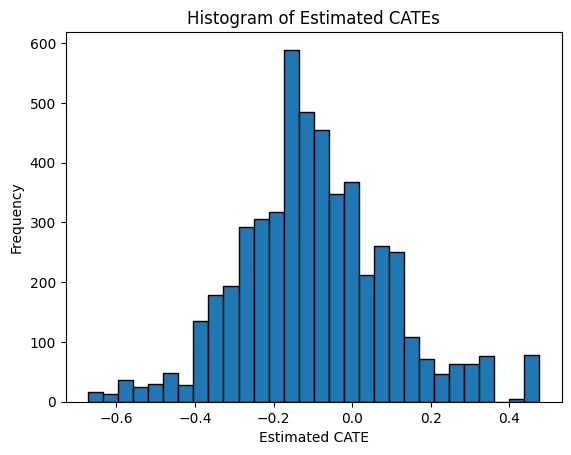

In [49]:
# plot histogram of CATEs
import matplotlib.pyplot as plt
plt.hist(cateX, bins=30, edgecolor="black")
plt.xlabel("Estimated CATE")
plt.ylabel("Frequency")
plt.title("Histogram of Estimated CATEs")
plt.show()

In [50]:
# double machine learning based on the random forest
ml_g = learner     # outcome model E(Y|D,X)
ml_m = RandomForestClassifier()     # treatment model E(D|X)
est=dml.DoubleMLIRM(dml_data_bonus, ml_g, ml_m, normalize_ipw=True,
                            trimming_rule='truncate', trimming_threshold=0.01)
est.fit()   # fit the model
print(est)  # ATE estimate

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


================== DoubleMLIRM Object ==================

------------------ Data Summary      ------------------
Outcome variable: inuidur1
Treatment variable(s): ['tg']
Covariates: ['female', 'black', 'othrace', 'dep1', 'dep2', 'q2', 'q3', 'q4', 'q5', 'q6', 'agelt35', 'agegt54', 'durable', 'lusd', 'husd']
Instrument variable(s): None
No. Observations: 5099


------------------ Score & Algorithm ------------------
Score function: ATE

------------------ Machine Learner   ------------------
Learner ml_g: RandomForestRegressor(max_features='sqrt')
Learner ml_m: RandomForestClassifier()
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[1.2678348]]
Learner ml_g1 RMSE: [[1.30524702]]
Classification:
Learner ml_m Log Loss: [[0.71379661]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit Summary       ------------------
        coef  std err         t     P>|t|     2.5 %    97.5 %
tg -0.150748  0.08577 -1.75

/usr/local/lib/python3.12/dist-packages/doubleml/utils/_checks.py:194: UserWarning: Propensity predictions from learner RandomForestClassifier() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/doubleml/double_ml.py:1479: UserWarning: The estimated nu2 for tg is not positive. Re-estimation based on riesz representer (non-orthogonal).
  warnings.warn(msg, UserWarning)


In [51]:
# investigate effect heterogeneity w.r.t. gender and ethnicity
cateX = DataFrame(df_bonus.iloc[:, 5:9])
cates=est.cate(cateX)
cates.fit()    # estimate effect heterogeneity
print(cates)   # evaluate effect heterogeneity

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
              coef   std err         t     P>|t|    [0.025    0.975]
female   -0.098137  0.124313 -0.789434  0.429859 -0.341787  0.145513
black    -0.371637  0.349610 -1.063005  0.287780 -1.056861  0.313586
hispanic  0.169235  0.865627  0.195506  0.844997 -1.527363  1.865833
othrace   0.521485  0.424136  1.229521  0.218876 -0.309807  1.352776


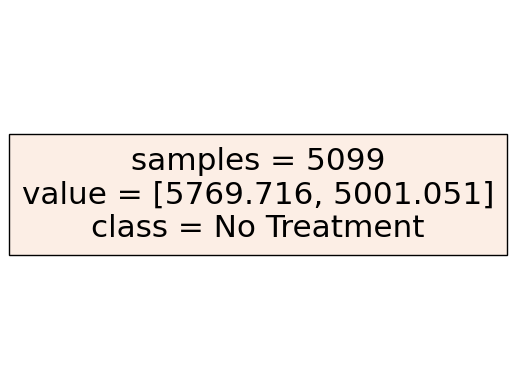

In [52]:
# optimal policy learning
policy_tree=est.policy_tree(features=X, depth=3)
policy_tree.plot_tree();

Marketing Data

In [53]:
# Double Machine Learning
import pandas as pd                                      # load pandas library
import doubleml as dml                                   # load doubleml library
from sklearn import linear_model                         # load from sklearn
df = pd.read_csv("https://raw.githubusercontent.com/MHfr/CMLpython/main/coupon.csv") # load coupon data
X = df.drop(['dailyspending', 'coupons'], axis = 1)      # define covariates
dml_data = dml.DoubleMLData(df,                          # create data
y_col = 'dailyspending',                                 # define outcome
d_cols = 'coupons',                                      # define intervention
x_cols = list(X.columns.values))                         # define covariates
ml_l = linear_model.LassoCV()                            # learner for outcome
ml_m = linear_model.LogisticRegressionCV(penalty = 'l1', # learner for treatment
solver = 'saga',                                         # solver
max_iter = 350,                                          # max. iterations
Cs = 1,                                                  # inverse regularization
tol = 0.01)                                              # tolerance for stopping
dml_lasso = dml.DoubleMLPLR(dml_data,                    # double machine learning
ml_l,                                                    # outcome model
ml_m,                                                    # treatment model
n_folds = 3).fit()                                       # number of folds
print(dml_lasso.summary)                                 # show the results

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              coef    std err         t     P>|t|      2.5 %     97.5 %
coupons  56.484695  17.142961  3.294921  0.000984  22.885109  90.084281


In [54]:
# Causal Forest
import pandas as pd                                      # load pandas library
import matplotlib.pyplot as plt                          # load matplotlib library
from econml.dml import CausalForestDML                   # load CausalForest from econml
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier  # load base models

df = pd.read_csv("https://raw.githubusercontent.com/MHfr/CMLpython/main/coupon.csv") # load coupon data
df.columns = df.columns.astype(str)                      # convert column names to strings

Y = df[['dailyspending']]                                # define outcome as DataFrame
D = df[['coupons']]                                      # define treatment as DataFrame
X = df.drop(['dailyspending', 'coupons'], axis=1)        # define covariates

est = CausalForestDML(criterion='het',                   # use criterion for heterogeneity
                      n_estimators=500,                  # number of trees
                      min_samples_leaf=10,               # minimum samples per leaf
                      max_depth=10,                      # maximum tree depth
                      max_samples=0.5,                   # subsample ratio
                      discrete_treatment=True,           # binary treatment
                      model_y=RandomForestRegressor(max_features='sqrt'),  # base model for outcome
                      model_t=RandomForestClassifier())  # base model for treatment

est.fit(Y=Y, T=D, X=X, W=X)                              # fit causal forest

cateX = est.effect(X)                                    # compute CATEs
lb, ub = est.effect_interval(X, alpha=0.05)              # confidence intervals via bootstrap

cates = pd.concat([pd.DataFrame(cateX),                  # combine CATEs
                   pd.DataFrame(lb),                     # lower bounds
                   pd.DataFrame(ub)], axis=1)            # upper bounds
cates.columns = ['CATE', 'Lower Bound', 'Upper Bound']   # rename columns
print(cates)                                             # print CATE table

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


            CATE  Lower Bound  Upper Bound
0     -65.512229  -203.754127    72.729668
1      55.844218     0.194353   111.494084
2      39.346929    -7.355536    86.049394
3      45.411514  -115.732746   206.555773
4      45.411514  -115.732746   206.555773
...          ...          ...          ...
1288  274.946684    61.168204   488.725164
1289   92.782047   -17.198250   202.762343
1290  -58.588017  -215.192471    98.016437
1291   42.439986   -59.289423   144.169394
1292  -58.588017  -215.192471    98.016437

[1293 rows x 3 columns]


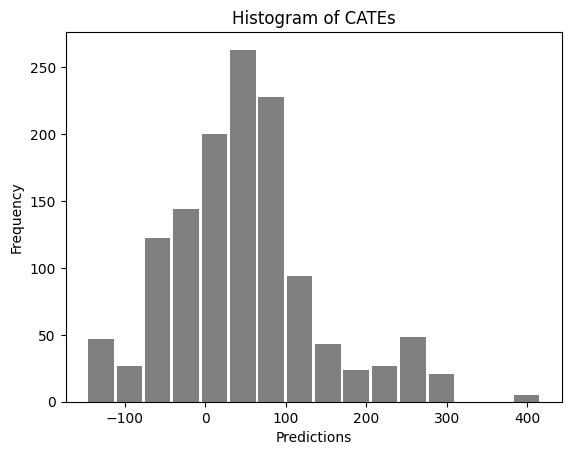

In [55]:
plt.hist(cateX, color='gray', bins=16, rwidth=0.9)       # plot histogram of CATEs
plt.xlabel('Predictions')                                # set x-axis label
plt.ylabel('Frequency')                                  # set y-axis label
plt.title('Histogram of CATEs')                          # set plot title
plt.show()                                               # show plot

In [56]:
importances = est.feature_importances_        # importances of X in causal forest
importances = importances.ravel() if importances.ndim > 1 else importances
feature_names = X.columns                     # extract names of X
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances                 # use flattened importances
})
print(importance_df)                          # report importances of X

                   Feature  Importance
0        coupons_preperiod    0.016506
1  dailyspending_preperiod    0.589440
2           income_bracket    0.136898
3                age_range    0.081145
4                  married    0.019441
5                   rented    0.014720
6              family_size    0.141849


In [57]:
# Double Machine Learning for effect heterogeneity analysis
import pandas as pd                                 # load pandas library
import numpy as np                                  # load numpy library
import doubleml as dml                              # load doubleml library
from sklearn import ensemble                        # load ensemble from sklearn
df = pd.read_csv("https://raw.githubusercontent.com/MHfr/CMLpython/main/coupon.csv") # load coupon data
X = df.drop(['dailyspending', 'coupons'], axis = 1) # select covariates
dml_data = dml.DoubleMLData(df,                     # create data
y_col = 'dailyspending',                            # define outcome
d_cols = 'coupons',                                 # define intervention
x_cols = list(X.columns.values))                    # define covariates
ml_g = ensemble.RandomForestRegressor(max_features = 'sqrt') # outcome model
ml_m = ensemble.RandomForestClassifier()            # intervention model
out = dml.DoubleMLIRM(dml_data,                     # double machine learning
ml_g,                                               # learner for outcome
ml_m,                                               # learner for intervention
normalize_ipw = True,                               # normalize weights
trimming_rule = 'truncate',                         # trimming approach
trimming_threshold = 0.01).fit()                    # threshold for trimming
df['intercept'] = np.ones(len(df))                  # create constant
cateX = df.loc[:, ['intercept', 'dailyspending_preperiod']] # X for heterogeneity
CATEs = out.cate(cateX)                             # estimate effect heterogeneity
print(CATEs)                                        # CATEs by past spending

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
                              coef    std err         t     P>|t|     [0.025  \
intercept                72.707201  59.785136  1.216142  0.223931 -44.469513   
dailyspending_preperiod   0.124385   0.104963  1.185034  0.236004  -0.081339   

                             0.975]  
intercept                189.883915  
dailyspending_preperiod    0.330110  


/usr/local/lib/python3.12/dist-packages/doubleml/utils/_checks.py:194: UserWarning: Propensity predictions from learner RandomForestClassifier() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/doubleml/double_ml.py:1479: UserWarning: The estimated nu2 for coupons is not positive. Re-estimation based on riesz representer (non-orthogonal).
  warnings.warn(msg, UserWarning)


[Text(0.5, 0.8333333333333334, 'family_size <= 4.5\nsamples = 1293\nvalue = [233933.593, 371283.232]\nclass = Treatment'),
 Text(0.25, 0.5, 'age_range <= 4.5\nsamples = 1140\nvalue = [185169.969, 345446.033]\nclass = Treatment'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'samples = 876\nvalue = [138361.604, 316081.755]\nclass = Treatment'),
 Text(0.375, 0.16666666666666666, 'samples = 264\nvalue = [46808.365, 29364.278]\nclass = No Treatment'),
 Text(0.75, 0.5, 'dailyspending_preperiod <= 19.555\nsamples = 153\nvalue = [48763.624, 25837.199]\nclass = No Treatment'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'samples = 63\nvalue = [32611.137, 5401.781]\nclass = No Treatment'),
 Text(0.875, 0.16666666666666666, 'samples = 90\nvalue = [16152.487, 20435.418]\nclass = Treatment')]

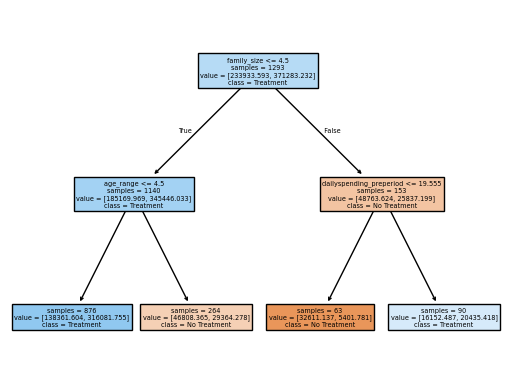

In [58]:
# Optimal policy tree
policy_tree = out.policy_tree(features = X, depth = 2) # policies for 4 subgroups
policy_tree.plot_tree()                                # tree with optimal policy

Private Pension Plan Data

In [59]:
# Instrumental variable-based estimation
import pandas as pd                                   # load pandas library
import pandas as pd                                   # load pandas library
from sklearn.linear_model import LogisticRegressionCV # load LogisticRegressionCV
from econml.iv.dr import ForestDRIV                   # load ForestDRIV
import math                                           # load math library
df = pd.read_csv("https://raw.githubusercontent.com/MHfr/CMLpython/main/c401k.csv") # load c401k data
X = df.iloc[:, 4:11]                                  # select covariates
Y = df.iloc[:, 1]                                     # select outcome
W = df.iloc[:, 2]                                     # select treatment
Z = df.iloc[:, 3]                                     # select instrument
ivforest = ForestDRIV(n_estimators = 2000,            # IV forest
                     min_samples_leaf = 5,            # specify min samples leaf
                     max_depth = min(round(math.sqrt(len(X.columns)))+20, len(X.columns)),
                     model_t_xw = LogisticRegressionCV(max_iter = 350),
                     discrete_treatment = True)       # discrete intervention
ivforest.fit(Y = Y, T = W, Z = Z, X = X)              # fit IV forest with data
ATE = ivforest.ate(X)                                 # compute ATE
INF = ivforest.ate_inference(X)                       # compute p-value
print(ATE)                                            # show ATE
print(INF)                                            # show p-value

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

12.294335236980523
               Uncertainty of Mean Point Estimate              
mean_point stderr_mean zstat pvalue ci_mean_lower ci_mean_upper
---------------------------------------------------------------
    12.294       9.944 1.236  0.216        -7.196        31.785
      Distribution of Point Estimate     
std_point pct_point_lower pct_point_upper
-----------------------------------------
   12.305           -2.82          40.969
     Total Variance of Point Estimate     
stderr_point ci_point_lower ci_point_upper
------------------------------------------
      15.821         -5.157         46.625
------------------------------------------

Note: The stderr_mean is a conservative upper bound.
